In [1]:
import os
import sys
import math
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add parent directory to path to find data_handling.py
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_susz_4x4/measurements
Running on: cpu


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        # Good initialization for RBMs
        nn.init.normal_(self.W, std=0.01)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        """
        Computes the Z2-symmetrized Free Energy efficiently.
        F_sym(v) = -T * log( exp(-F(v)/T) + exp(-F(-v)/T) )
        """
        v = v.to(dtype=self.W.dtype, device=self.W.device)

        # 1. Compute the raw matrix product ONCE
        v_W = v @ self.W  # (Batch, Hidden)

        # 2. Compute row sums of W ONCE
        W_sum = self.W.sum(dim=0)  # (Hidden,)

        # 3. Construct linear terms
        # Normal:   H = v@W + c_mod
        linear_v = v_W + c_mod
        # Flipped:  H = (1-v)@W + c_mod  =>  sum(W) - v@W + c_mod
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod

        # 4. Non-linearity (Softplus)
        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_flip).sum(dim=-1)

        # 5. Bias Terms
        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        # 6. Individual Free Energies
        fe_v = term1_v - term2_v
        fe_flipped = term1_f - term2_f

        # 7. Symmetrize via LogSumExp
        # Returns -T * log( P(v) + P(not v) )
        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        # Broadcasting logic
        if cond.dim() == 1: # Single condition for whole batch
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else: # Batch of conditions
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        # returns log(psi) = -0.5 * FE / T
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)

        rng = aux_vars.get("rng")
        b_mod, c_mod = self._compute_effective_biases(cond)

        # CD-k
        v_model = v_data.clone()

        # Training Noise (Crucial for exploring modes)
        n_noise = int(v_data.shape[0] * aux_vars.get("noise_frac", 0.1))
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, rng)
        v_model = v_model.detach()

        # Compute Loss
        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = (fe_data - fe_model).mean()

        return loss, {}

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, n_samples: int, rng: torch.Generator):
        """Generates samples for a given condition"""
        cond = cond.to(device)
        # Repeat condition for batch
        if cond.dim() == 1:
            cond_batch = cond.expand(n_samples, -1)
        else:
            cond_batch = cond

        b_mod, c_mod = self._compute_effective_biases(cond_batch)

        # Start from uniform noise
        probs = torch.full((n_samples, self.num_visible), 0.5, device=device)
        v = torch.bernoulli(probs, generator=rng)

        # Run chain for longer than training k to equilibrate
        for _ in range(self.k * 2):
            v = self._gibbs_step(v, b_mod, c_mod, rng)

        return v

In [9]:
@torch.no_grad()
def compute_fidelity_susceptibility_rbm(model, h_center, delta_h=1e-3, n_samples=10000, rng=None):
    """
    Computes Fidelity Susceptibility using the Double-Sampling Quotient Method.
    chi_F = - d^2 ln(F) / d_eps^2
    F = <Psi(h)|Psi(h+d)> / Norms
    """
    if rng is None: rng = torch.Generator(device=device)

    # --- FIX: Explicitly set dtype to match the model (float32) ---
    model_dtype = next(model.parameters()).dtype

    # 1. Prepare Conditions
    # h_center is likely a numpy float64, so we force float32 here
    cond_h = torch.tensor([[h_center]], device=device, dtype=model_dtype)
    cond_plus = torch.tensor([[h_center + delta_h]], device=device, dtype=model_dtype)

    # Expand for batch processing
    cond_h_batch = cond_h.expand(n_samples, -1)
    cond_plus_batch = cond_plus.expand(n_samples, -1)

    # 2. Generate Samples from Both Distributions
    # Samples from P(h) ~ |Psi(h)|^2
    samples_h = model.generate(cond_h, n_samples, rng)
    # Samples from P(h+d) ~ |Psi(h+d)|^2
    samples_plus = model.generate(cond_plus, n_samples, rng)

    # 3. Compute Log-Amplitudes for Cross-Evaluation
    # Evaluating samples_h
    log_psi_h_on_h = model.log_score(samples_h, cond_h_batch)
    log_psi_plus_on_h = model.log_score(samples_h, cond_plus_batch)

    # Evaluating samples_plus
    log_psi_plus_on_plus = model.log_score(samples_plus, cond_plus_batch)
    log_psi_h_on_plus = model.log_score(samples_plus, cond_h_batch)

    # 4. Compute Ratios (Quotients)
    # r1 = Psi(h+d) / Psi(h) evaluated on samples from h
    log_r1 = log_psi_plus_on_h - log_psi_h_on_h
    r1 = torch.exp(log_r1)

    # r2 = Psi(h) / Psi(h+d) evaluated on samples from h+d
    log_r2 = log_psi_h_on_plus - log_psi_plus_on_plus
    r2 = torch.exp(log_r2)

    # 5. Compute Normalized Overlap (Fidelity)
    # F = E[r1] * E[r2]
    overlap = r1.mean() * r2.mean()

    # 6. Convert to Susceptibility
    # chi_F = -2 * ln(F) / delta_h^2
    chi = -2.0 * torch.log(overlap) / (delta_h**2)

    return chi.item()

In [5]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train(model, optimizer, loader, num_epochs, rng, lr_schedule_fn):
    global_step = 0
    model.train()
    training_noise_frac = 0.1 # Crucial for mixing

    print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
    print("-" * 30)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

        avg_loss = tot_loss / len(loader)
        print(f"{epoch+1:<6} | {avg_loss:+.4f}     | {lr:.6f}")

    return model

In [7]:
# CONFIG
SIDE_LENGTH = 4
TRAIN_SAMPLES = 50_000
h_support = [2.00, 2.50, 3.20, 4.00]

# Load Data
file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{5000000}.npz" for h in h_support] # Assuming big files exist
file_paths = [data_dir / fn for fn in file_names]
# Note: You might need to adjust filename logic if your files are named differently
# e.g. using glob if you are unsure of the sample count in the filename
print(f"Loading files: {file_paths}")

ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [TRAIN_SAMPLES]*len(file_paths))
print(f"Dataset Size: {len(ds)}")

# Setup Training
batch_size = 1024
num_epochs = 20
k_steps = 10 # Increase CD steps for better equilibration
init_lr = 1e-2

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator(device=device).manual_seed(SEED)
loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

# Init Model
model = ConditionalRBM(ds.num_qubits, num_hidden=32, cond_dim=1, conditioner_width=64, k=k_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
scheduler = get_sigmoid_curve(init_lr, 1e-4, num_epochs*len(loader), 0.005)

# Train
model = train(model, optimizer, loader, num_epochs, rng, scheduler)

Loading files: [PosixPath('measurements/tfim_4x4_h2.00_5000000.npz'), PosixPath('measurements/tfim_4x4_h2.50_5000000.npz'), PosixPath('measurements/tfim_4x4_h3.20_5000000.npz'), PosixPath('measurements/tfim_4x4_h4.00_5000000.npz')]
Dataset Size: 200000
Epoch  | Loss       | LR        
------------------------------
1      | +0.0437     | 0.009999
2      | +0.0194     | 0.009996
3      | +0.0099     | 0.009990
4      | +0.0160     | 0.009973
5      | +0.0080     | 0.009927
6      | -0.0022     | 0.009808
7      | -0.0068     | 0.009505
8      | +0.0025     | 0.008783
9      | +0.0044     | 0.007308
10     | +0.0040     | 0.005062
11     | +0.0010     | 0.002811
12     | -0.0012     | 0.001328
13     | -0.0040     | 0.000599
14     | -0.0067     | 0.000294
15     | +0.0003     | 0.000174
16     | -0.0049     | 0.000128
17     | +0.0002     | 0.000110
18     | -0.0052     | 0.000104
19     | -0.0082     | 0.000101
20     | -0.0024     | 0.000101



=== EVALUATION SWEEP: FIDELITY SUSCEPTIBILITY ===
Scanning h from 2.0 to 4.0 (30 points)
h=2.966 | chi=2.6226
h=3.034 | chi=-33.6167
h=3.103 | chi=-1.9073
h=3.172 | chi=-0.4768



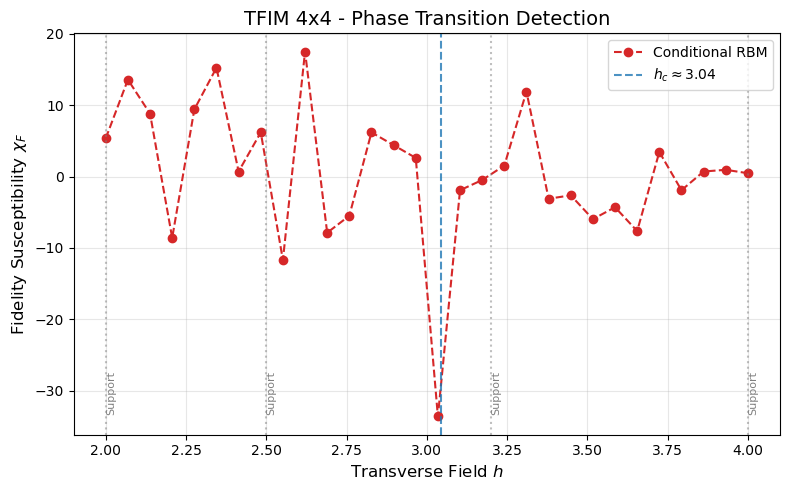

In [10]:
# EVAL CONFIG
h_eval_min = 2.0
h_eval_max = 4.0
n_eval_points = 30
delta_h = 1e-3 # Step size for numerical derivative

h_eval_values = np.linspace(h_eval_min, h_eval_max, n_eval_points)
rbm_chi_values = []

print("\n=== EVALUATION SWEEP: FIDELITY SUSCEPTIBILITY ===")
print(f"Scanning h from {h_eval_min} to {h_eval_max} ({n_eval_points} points)")

rng_eval = torch.Generator(device=device).manual_seed(1234)

for h_val in h_eval_values:
    # Use the Quotient Method to estimate Chi_F
    # Note: h_val is numpy.float64, but the fix in Cell 3 handles the cast now.
    chi = compute_fidelity_susceptibility_rbm(model, h_val, delta_h=delta_h, n_samples=20000, rng=rng_eval)
    rbm_chi_values.append(chi)

    # Print progress for critical region
    if 2.9 < h_val < 3.2:
        print(f"h={h_val:.3f} | chi={chi:.4f}")

# LOAD REFERENCE
ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_fidelity_ref.csv")
if ref_file.exists():
    ref_df = pd.read_csv(ref_file)
    print(f"\nLoaded reference data from {ref_file}")
else:
    ref_df = None
    print("\nWARNING: Reference file not found. Plotting RBM only.")

# PLOT
plt.figure(figsize=(8, 5), dpi=100)

# Plot Reference (Exact)
if ref_df is not None:
    plt.plot(ref_df["h"], ref_df["chi_F"], '-', color='black', alpha=0.6, linewidth=2, label="Exact Diagonalization")

# Plot RBM
plt.plot(h_eval_values, rbm_chi_values, 'o--', color='tab:red', markersize=6, label="Conditional RBM")

# Add Support Points markers
ymin, ymax = plt.ylim()
for h_supp in h_support:
    if h_eval_min <= h_supp <= h_eval_max:
        plt.axvline(h_supp, color='gray', linestyle=':', alpha=0.5)
        plt.text(h_supp, ymin + (ymax-ymin)*0.05, 'Support', rotation=90, verticalalignment='bottom', color='gray', fontsize=8)

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility $\chi_F$", fontsize=12)
plt.title(f"TFIM 4x4 - Phase Transition Detection", fontsize=14)

# Theoretical Critical Point (2D)
plt.axvline(3.044, color="tab:blue", linestyle="--", alpha=0.8, label=r"$h_c \approx 3.04$")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()